In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as cx
from Ames_Functions import *
from shapely.geometry import Point
pd.set_option("display.max_columns", None)

In [232]:
df_house_2021 = load_state_pkl()["df_RE_latlong2021"][0].set_index("SaleID")
df_house_2019 = load_state_pkl()["df_RE_latlong2019"][0].set_index("SaleID")
df_house_both = df_house_2019.append(df_house_2021)
df_biz = pd.read_csv("df_EssentialLatLong_v2.csv")
df_shp = gpd.read_file("Ames_Precinct_Boundaries/Ames_-_Precincts_2.shp")
df_feature_all2021 = load_state_pkl()['df_house2021_after_feature_engineering'][0]
df_feature_all2019 = load_state_pkl()['df_house2019_after_feature_engineering'][0]
df_feature_all_encoded = load_state_pkl()['Final_Model'][0]['df_features_all_encoded']

/var/folders/2n/5k95xl754cb_szsgjkmj33k80000gn/T/ipykernel_1985/1354282213.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_house_both = df_house_2019.append(df_house_2021)


In [4]:
wm_house_dict = {}
df_wm_house = gpd.GeoDataFrame(df_house_both.join(df_house_both.apply(lambda x: Point(x.Long, x.Lat), axis = 1).rename("geometry")), crs = "epsg:4326").to_crs(epsg = 3857)
#wm_house_dict["2021"] = gpd.GeoDataFrame(df_house_2021.join(df_house_2021.apply(lambda x: Point(x.Long, x.Lat), axis = 1).rename("geometry")), crs = "epsg:4326").to_crs(epsg = 3857)
df_wm_biz = gpd.GeoDataFrame(df_biz.join(df_biz.apply(lambda x: Point(x.Long, x.Lat), axis = 1).rename("geometry")), crs = "epsg:4326").to_crs(epsg = 3857).eval("biz_num = index + 1")

In [37]:
df_wm = df_shp.to_crs(epsg = 3857)

## Housing Visualizations/Maps Testing and Stylizing Section

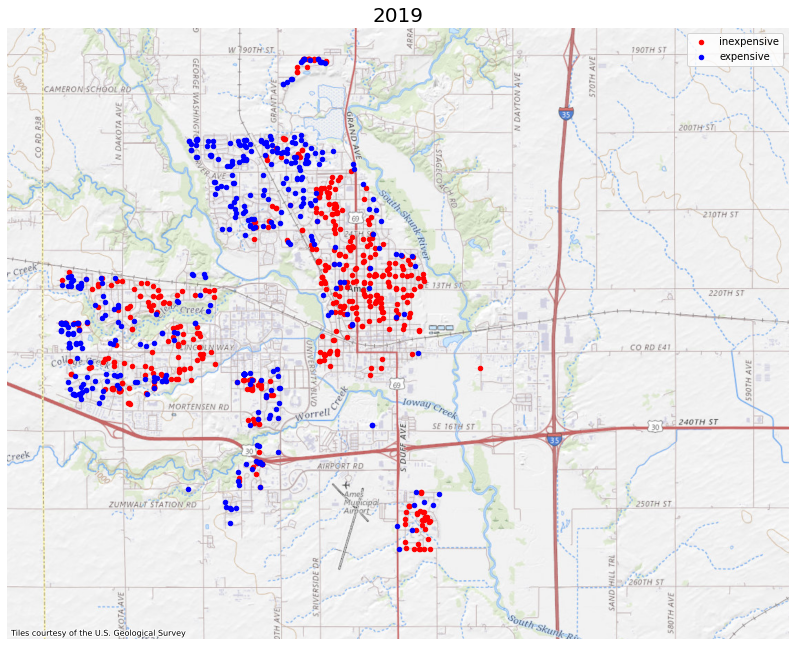

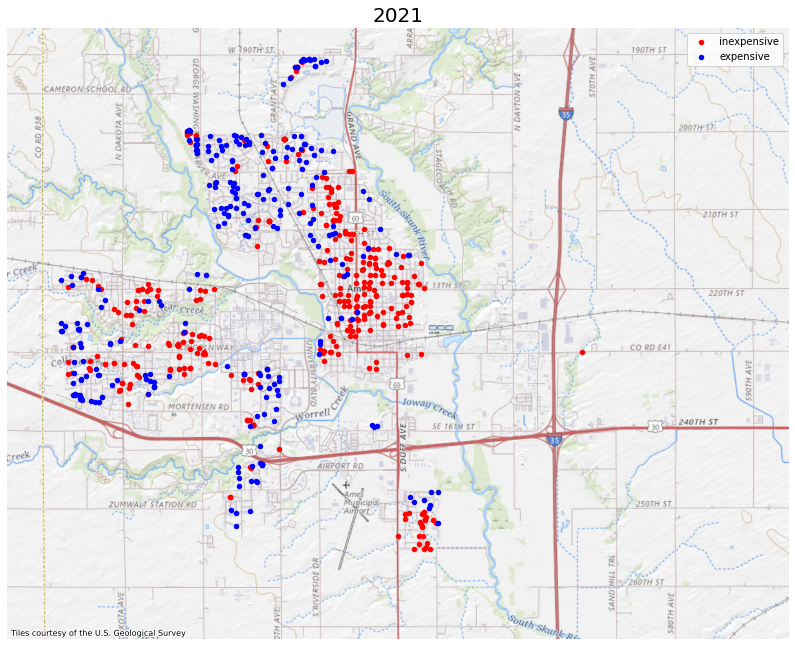

In [89]:
for year in ["2019", "2021"]:
    ax = df_wm.query("index > 0").plot(figsize = (14,14), alpha = 0)
    wm_house_dict[year].query("SalePrice <= SalePrice.mean()").plot(ax = ax, markersize = 20, color = "red", marker = "o", label = "inexpensive")
    wm_house_dict[year].query("SalePrice > SalePrice.mean()").plot(ax = ax, markersize = 20, color = "blue", marker = "o", label = "expensive")
    cx.add_basemap(ax = ax, source = cx.providers.USGS.USTopo)
    plt.axis("off")
    plt.title(year, fontdict = {"fontsize":"20"})
    plt.legend()
    plt.show()
    #df_shp.query("index >= 5").plot(ax = ax, figsize = (14,14), color = "red", edgecolor = "black")

In [ ]:
provider = 
for src in cx.providers[provider].keys():
    ax = df_wm.query("index > 0").plot(figsize = (16,16), alpha = 0)
    print(src)
    cx.add_basemap(ax = ax, source = cx.providers[provider][src])
    plt.axis("off")
    plt.show()

# OpenStreetMap:
# BZH and HOT decent resolution, not too busy
# DE decent resolution, somewhat busy

# OpenTopoMap:
# url really good resolution, slightly busy

# Esri:
# NatGeoWorldMap muted tones so house dots would stand out, not very busy
# WorldStreetMap 

# USGS
# USTopo pretty muted except for roads

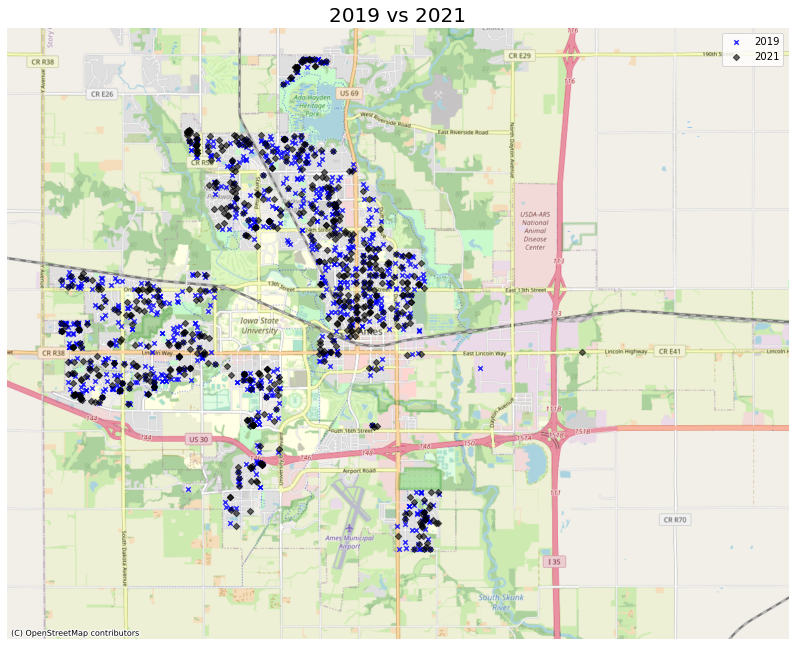

In [43]:
ax = df_wm.query("index > 0").plot(figsize = (14,14), alpha = 0)
wm_house_dict["2019"].plot(ax = ax, markersize = 20, color = "blue", marker = "x", label = "2019", alpha = 0.8)
wm_house_dict["2021"].plot(ax = ax, markersize = 20, color = "k", marker = "D", label = "2021", alpha = 0.6)
cx.add_basemap(ax = ax, source = cx.providers.OpenStreetMap.Mapnik)
plt.axis("off")
plt.title("2019 vs 2021", fontdict = {"fontsize": "20"})
plt.legend()
plt.show()

## Housing Map Section for Presentation

### Housing Data Slide Visuals

In [77]:
#Creating Categorical variables for display before plotting them out
df_wm_house.SalePrice.describe()
cond_list = [df_wm_house.SalePrice < 165000, df_wm_house.SalePrice < 225000, df_wm_house.SalePrice < 300000, df_wm_house.SalePrice < 500000]
names_list = ["< 165k", "165k to 225k", "225k to 300k", "300k to 500k"]
df_wm_house = df_wm_house.join(pd.Series(np.select(cond_list, names_list, "> 500k"), name = "SalePrice_Groups", index = df_wm_house.index))
#(900, 165000), (165000, 225000), (225k, 300k), (300k, 500k), (500k, 800k)
#pd.cut(df_wm_house.SalePrice, bins = 5)

In [190]:
year = 2019
attr = "SalePrice_Groups"
df_wm_house.query("YrSold_YYYY == @year")[attr].unique()

array(['< 165k', '> 300k', '165k to 225k', '225k to 300k'], dtype=object)

In [204]:
def plot_by_attribute (attr):
    fig,axs = plt.subplots(2,2, figsize = (18,18))
    for r,c in [(row, col) for row in range(2) for col in range(2)]:
        year = "2019" if r == 0 else "2021"
        cond = f"{attr} <= {attr}.mean()" if c == 0 else f"{attr} > {attr}.mean()"
        ax = axs[r,c]
        df_wm.query("index > 0").plot(ax = ax, alpha = 0)
        wm_house_dict[year].query(cond).plot(ax = ax, markersize = 20, color = "red", marker = "o")
        #wm_house_dict[year].query(f"{attr} > {attr}.mean()").plot(ax = ax, markersize = 20, color = "blue", marker = "o", label = f"{attr} above mean")
        cx.add_basemap(ax = ax, source = cx.providers.USGS.USTopo)
        ax.axis("off")
        ax.set_title(f"{year} : {cond}", fontdict = {"fontsize":"20"})
    #df_shp.query("index >= 5").plot(ax = ax, figsize = (14,14), color = "red", edgecolor = "black")

#SEE NEW FUNCTION IN BELOW CELL
# def plot_by_categorical_attribute (attr, order = None):
#     attr_list = df_wm_house.query("YrSold_YYYY == @year")[attr].unique()
#     if order is not None:
#         attr_list = attr_list[order]
#     num_ax = attr_list.shape[0]
#     fig,axs = plt.subplots(num_ax,2, figsize = (18,18))
#     for r,c in [(row, col) for row in range(num_ax) for col in range(2)]:
#     #fig,axs = plt.subplots(num_ax//4 + 1, 4, figsize = (25,25))
#     for i,ax in enumerate(axs.ravel()): #[(row, row, 1) for row in range(num_ax)]:
#         #year = "2019" if r == 0 else "2021"
#         if i >= num_ax:
#             ax.axis("off")
#             continue
#         cond = f"{attr} == \"{attr_list[i]}\""
#         #ax = axs[r]
#         df_wm.query("index > 0").plot(ax = ax, alpha = 0)
#         df_wm_house.query("YrSold_YYYY == @year").query(cond).plot(ax = ax, markersize = 20, color = "red", marker = "o")
#         #wm_house_dict[year].query(f"{attr} > {attr}.mean()").plot(ax = ax, markersize = 20, color = "blue", marker = "o", label = f"{attr} above mean")
#         cx.add_basemap(ax = ax, source = cx.providers.USGS.USTopo)
#         ax.axis("off")
#         ax.set_title(f"{year} : {attr_list[i]}", fontdict = {"fontsize":"20"})
#     #df_shp.query("index >= 5").plot(ax = ax, figsize = (14,14), color = "red", edgecolor = "black")

In [75]:
df_wm_house[attr].unique()

array(['< $165k', '$300k to $500k', '> $500k', '$165k to $225k',
       '$225k to $300k'], dtype=object)

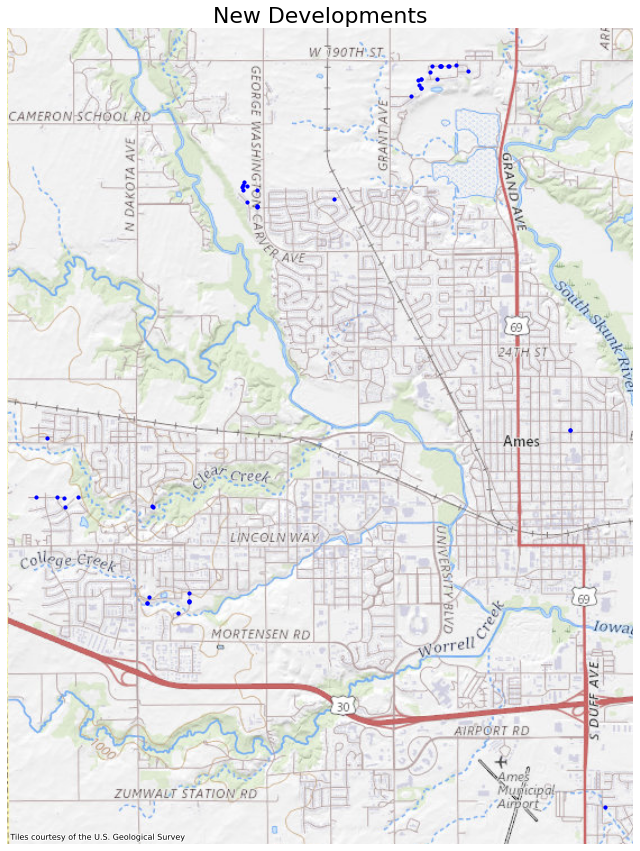

In [115]:
cond = "YrBuilt > YrSold_YYYY or YrBuilt == 0"
#df_wm_house.query("YrBuilt >= 2019 or YrBuilt == 0").YrBuilt
ax = df_wm_house.query(cond).plot(markersize = 10, color = "blue", marker = "o", figsize = (15,15))
cx.add_basemap(ax = ax, source = cx.providers.USGS.USTopo)
ax.set_title("New Developments", fontdict = {"fontsize": "22"})
ax.axis("off");

In [123]:
attr = "SalePrice_Groups"
df_wm_house.query("YrBuilt <= YrSold_YYYY and YrBuilt != 0")[attr].unique()

array(['300k to 500k', '< 165k', '> 500k', '165k to 225k', '225k to 300k'],
      dtype=object)

In [133]:
df_wm_house.SalePrice.describe()#.query("SalePrice > 350000").shape

count      1534.000000
mean     239764.835072
std      112906.114427
min         900.000000
25%      165624.750000
50%      222150.000000
75%      298975.000000
max      793000.000000
Name: SalePrice, dtype: float64

In [135]:
def plot_by_categorical_attribute (attr, order = None):
    attr_list = df_wm_house.query("YrBuilt <= YrSold_YYYY and YrBuilt != 0")[attr].unique()
    if order is not None:
        attr_list = attr_list[order]
    num_ax = attr_list.shape[0]
    fig,axs = plt.subplots(num_ax, 2, figsize = (20,50))
    fig.tight_layout()
    for r,c in [(row, col) for row in range(num_ax) for col in range(2)]:
        year = 2019 if c == 0 else 2021
        cond = f"{attr} == '{attr_list[r]}'"
        ax = axs[r, c]
        df_wm_house.query("YrBuilt <= YrSold_YYYY and YrBuilt != 0").query("YrSold_YYYY == @year and " + cond).plot(ax = ax, markersize = 10, color = "blue", marker = "o")
        ax.set_xlim((-1.0432e7, -1.0418e7))
        ax.set_ylim((5.158e6, 5.174e6))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        if r == 0:
            ax.set_title(year, fontdict = {"fontsize":"25"})
        if c == 0:
            ax.set_ylabel(attr_list[r], rotation = 0, fontdict = {"fontsize": "15"})
            ax.yaxis.set_label_coords(-0.1, 0.5)
        cx.add_basemap(ax = ax, source = cx.providers.USGS.USTopo)

In [ ]:
plot_by_categorical_attribute("SalePrice_Groups", [1, 3, 4, 0, 2])

In [180]:
#Function copy from above to change for plots by condition
def plot_by_condition (cond_list, color_list, marker_shape, labels):
    #attr_list = df_wm_house.query("YrBuilt <= YrSold_YYYY and YrBuilt != 0")[attr].unique()
    # if order is not None:
    #     attr_list = attr_list[order]
    # num_ax = [attr_list.shape[0]]
    fig,axs = plt.subplots(1, 2, figsize = (20,50))
    fig.tight_layout()
    for r,c in [(row, col) for row in range(1) for col in range(2)]:
        year = 2019 if c == 0 else 2021
        #cond = f"{attr} == '{attr_list[r]}'"
        ax = axs[c]
        for cond, colr, l in zip(cond_list, color_list, labels):
            df_wm_house.query("YrBuilt <= YrSold_YYYY and YrBuilt != 0").query("YrSold_YYYY == @year and " + cond).plot(ax = ax, markersize = 20, color = colr, marker = marker_shape, facecolors = "None", label = l)
        ax.set_xlim((-1.0432e7, -1.0418e7))
        ax.set_ylim((5.158e6, 5.174e6))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        if r == 0:
            ax.set_title(year, fontdict = {"fontsize":"25"})
        if c == 0:
            #ax.set_ylabel(attr_list[r], rotation = 0, fontdict = {"fontsize": "15"})
            ax.yaxis.set_label_coords(-0.1, 0.5)
        cx.add_basemap(ax = ax, source = cx.providers.USGS.USTopo, alpha = 0.6)
    plt.legend()

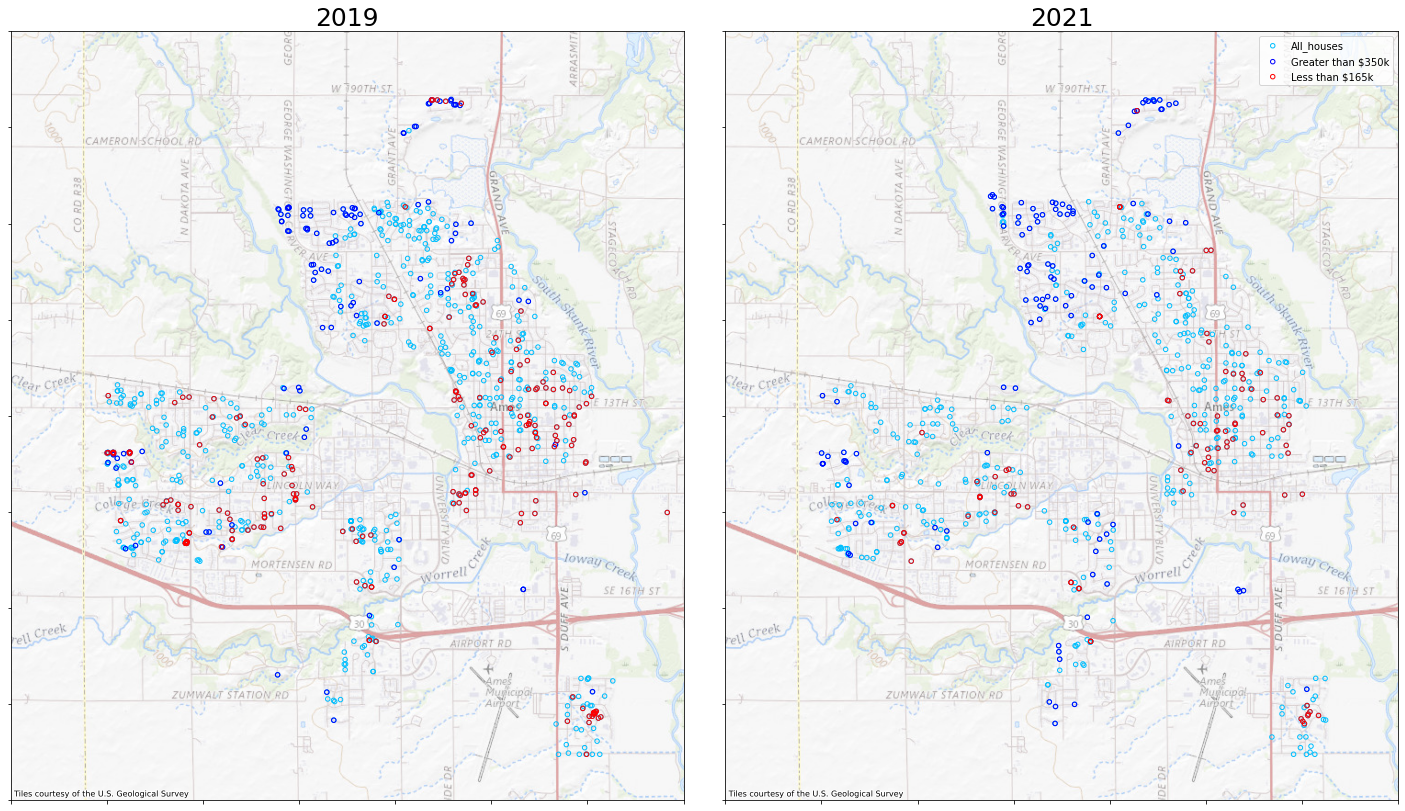

In [183]:
#Plotting SalePrice Extremes and rest of the houses
plot_by_condition(["True", "SalePrice > 350000", "SalePrice < 165000"], ["deepskyblue", "blue", "red"], "o", ["All_houses", "Greater than $350k", "Less than $165k"])

Number of Sales by Year and Month Bar Charts

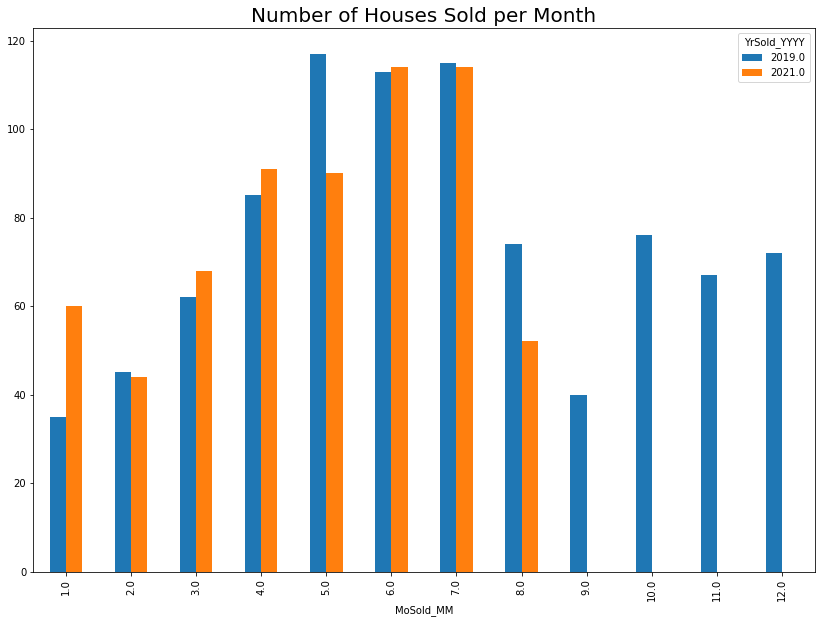

In [223]:
(df_wm_house
    .groupby(["YrSold_YYYY"]).MoSold_MM
    .value_counts()
    .unstack(level = 0)
    .plot(kind = "bar", 
          figsize = (14,10)
          )
)
plt.title("Number of Houses Sold per Month", fontsize = 20);

Show all Area/SF fields and engineered fields in one bar chart

Text(0.5, 1.0, 'Area Feature Averages by Year')

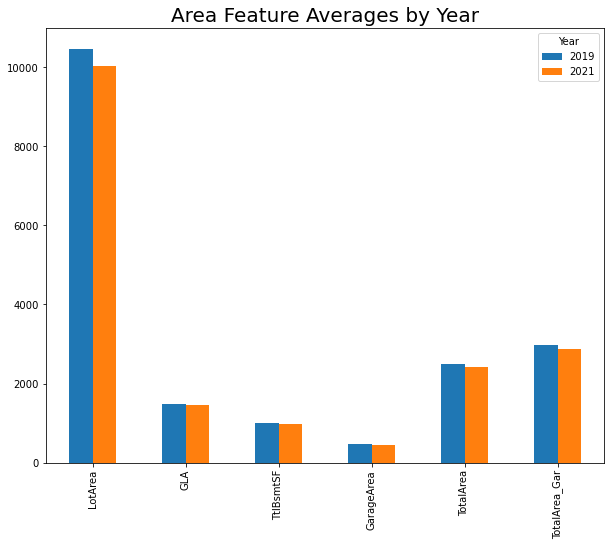

In [261]:
df_feature_all_encoded.filter(regex = "Area|SF|GLA|Year").drop("PoolArea", axis = 1).groupby("Year").mean().T.plot(kind = "bar", figsize = (10,8))
plt.title("Area Feature Averages by Year", fontsize = 20)

Show frequency table of “Has_” boolean fields


Text(0.5, 1.0, 'House Amenities by Year')

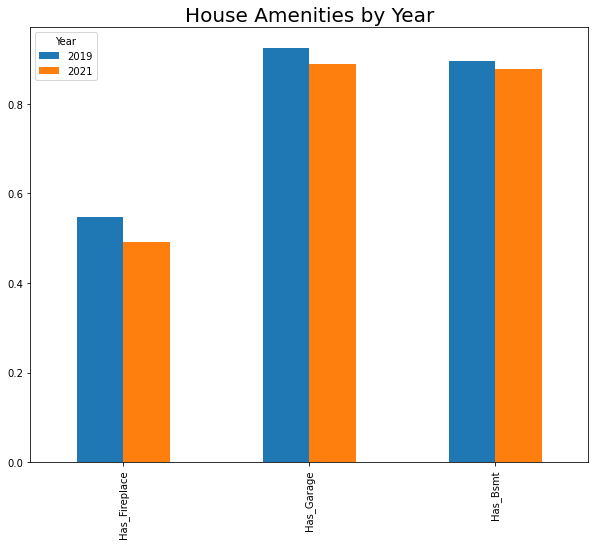

In [260]:
df_feature_all_encoded.filter(regex = "Has_|Year").groupby("Year").mean().T.plot(kind = "bar", figsize = (10,8))
plt.title("House Amenities by Year", fontsize = 20)

Show Correlations using heatmap to show which fields are more correlated to SalePrice


<AxesSubplot:>

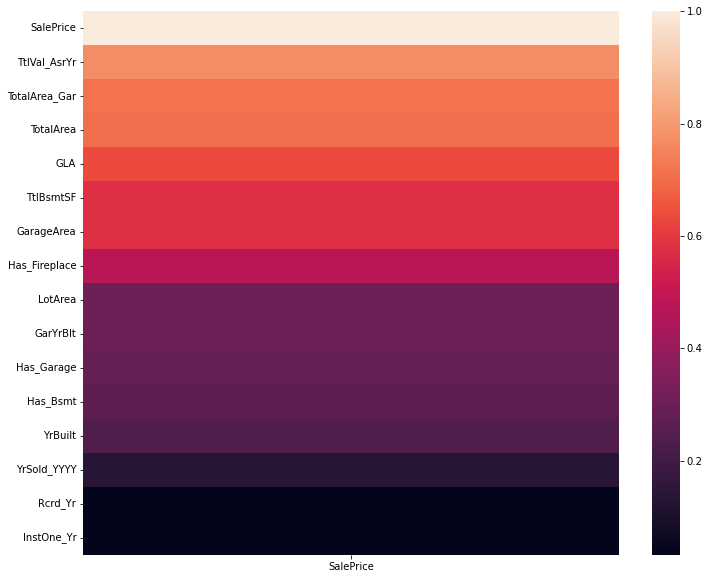

In [280]:
plt.figure(figsize = (12,10))
sns.heatmap(df_feature_all_encoded.filter(regex = "Has_|Area|GLA|SF|Yr").drop("PoolArea", axis = 1).join(df_wm_house.SalePrice).corr().SalePrice.sort_values(ascending = False).to_frame())


## Business/Service Locations Map

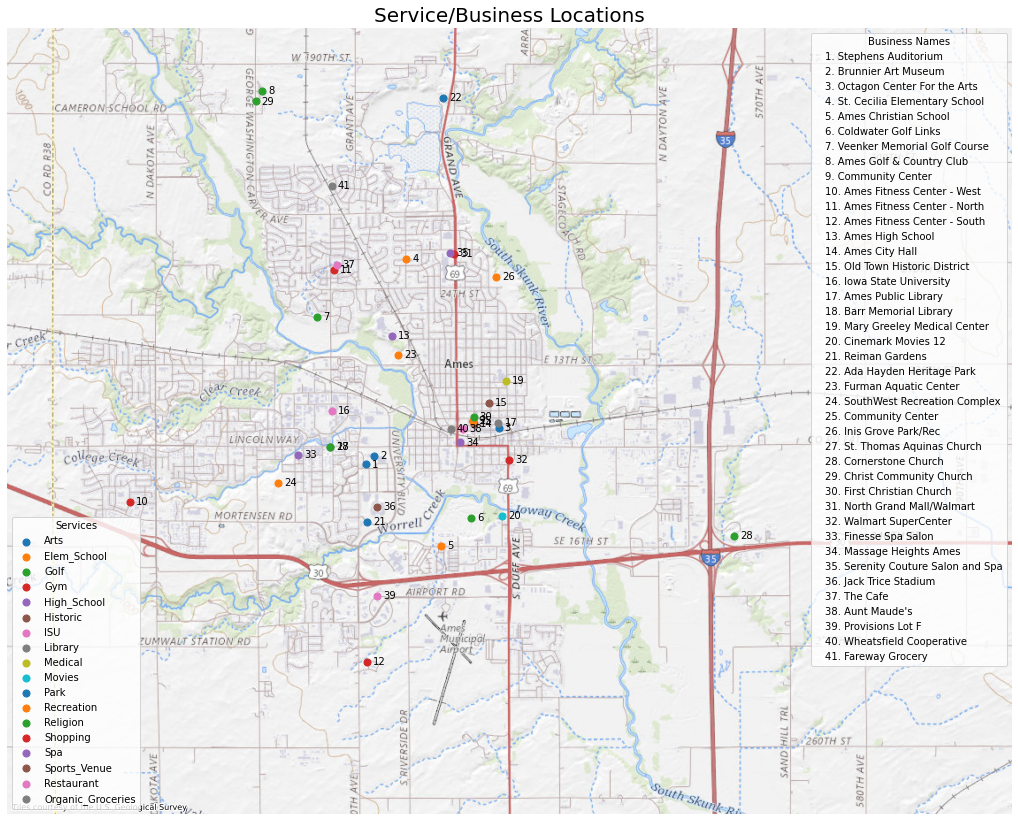

In [131]:
ax = df_wm.query("index > 0").plot(figsize = (18,18), alpha = 0)
for service in df_wm_biz.Service.unique():
    df_wm_biz.query(f"Service == '{service}'").plot(ax = ax, markersize = 50, marker = "o", label = service)

handles_nums = []

for row in df_wm_biz.iterrows():
    #print(row[1].Service, row[1].geometry)
    handles_nums.append(ax.annotate(row[1].biz_num, xy = (row[1].geometry.x, row[1].geometry.y), xytext = (6,-3), textcoords = "offset points"))
#df_wm_biz.query("Service == 'Gym'").plot(ax = ax, markersize = 50, color = "blue", marker = "o", label = "Gym")
cx.add_basemap(ax = ax, source = cx.providers.USGS.USTopo)
plt.axis("off")
#plt.xlim((-1.0425e7, -1.04175e7))
#plt.ylim((5.162e6, 5.168e6))
plt.title("Service/Business Locations", fontdict = {"fontsize":"20"})
legend1 = plt.legend(loc = "lower left", title = "Services")
plt.gca().add_artist(legend1)


legend2_elements = []
for text, biz_num in zip(df_wm_biz.Name, df_wm_biz.biz_num):
    legend2_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="white", markersize=8, label=str(biz_num) + ". " + text))
plt.legend(handles=legend2_elements, title='Business Names', loc='upper right', handletextpad = -1)

plt.show()

In [165]:
for row in df_wm_biz.iterrows():
    print(row[1].Service, row[1].geometry)
    #ax.annotate(service, xy = (df_wm_biz.geometry.x, df_wm_biz.geometry.y))

Arts POINT (-10423736.5015757 5164005.599215714)
Arts POINT (-10423545.13557866 5164197.092648083)
Arts POINT (-10420861.305032058 5164787.362271849)
Elem_School POINT (-10422856.502076663 5168445.01238308)
Elem_School POINT (-10422108.146781052 5162246.799768416)
Golf POINT (-10421447.730543582 5162852.620228477)
Golf POINT (-10424776.85234844 5167186.804309941)
Golf POINT (-10425965.688850367 5172076.212493404)
Gym POINT (-10421417.058684284 5164945.364719272)
Gym POINT (-10428820.59296403 5163195.805632814)
Gym POINT (-10424413.230571348 5168203.189980591)
Gym POINT (-10423702.02147662 5159728.720122781)
High_School POINT (-10423173.183764072 5166785.8346012775)
Historic POINT (-10421398.429367498 5164889.279215017)
Historic POINT (-10421069.174143607 5165326.53640378)
ISU POINT (-10424470.631353581 5165160.32724347)
Library POINT (-10420864.576711891 5164903.254853791)
Library POINT (-10424494.809946982 5164380.101001451)
Medical POINT (-10420696.608958624 5165811.724346088)
Movies